# Evaluate Hex Chess Engines

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
from hexchess import HexChessBoard, Player, RandomPlayer, GreedyPlayer
from engines import QNetworkPlayer
from utils import make_safe_filename
import tensorflow as tf

/var/tmp/ipykernel_8894/1742045968.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-04-08 01:08:53.701105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 01:08:54.631327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-08 01:08:54.631440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [3]:
gpus = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-04-08 01:08:55.727943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 01:08:55.850563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 01:08:55.852397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Constants
results_dir = "./assets/results"
os.makedirs(results_dir, exist_ok=True)

## Game Function

In [5]:
def play_game(white_player, black_player, board, max_moves = 50):
    # Reset board
    board.reset()

    # Play game
    n_moves = 0
    turn_is_white = True
    finished = False
    for _ in range(max_moves * 2):
        # Select active player
        active_player = white_player if turn_is_white else black_player

        # Get move
        position_from, position_to = active_player.get_move()
        success, finished = board.move(position_from, position_to, turn_is_white)

        # Update turn
        turn_is_white = not turn_is_white
        n_moves += 1 if turn_is_white else 0
        if finished:
            break

    # Determine winner (only valid if game is finished)
    white_won = not turn_is_white
    return finished, white_won, n_moves

In [6]:
def play_games(
    white_player_class,
    black_player_class,
    max_moves=50,
    n_games=10,
    progress_bar=True,
):
    # Parse player
    if isinstance(white_player_class, dict):
        white_player_kwargs = white_player_class['kwargs']
        white_player_class = white_player_class['class']
    else:
        white_player_kwargs = {}
    if isinstance(black_player_class, dict):
        black_player_kwargs = black_player_class['kwargs']
        black_player_class = black_player_class['class']
    else:
        black_player_kwargs = {}
    
    # Initialize board
    board = HexChessBoard(save_prob=0.)
    
    # Initialize players
    white_player = white_player_class(board, True, **white_player_kwargs)
    black_player = black_player_class(board, False, **black_player_kwargs)
    
    
    # Play games
    fn = tqdm if progress_bar else lambda x: x
    results = [None] * n_games
    for game_index in fn(range(n_games)):
        results[game_index] = play_game(
            white_player=white_player,
            black_player=black_player,
            board=board,
            max_moves=max_moves,
        )

    return results

## Evaluate Games

In [12]:
# Configuration
n_games = 1000
max_moves = 100
white_players = [
    {"class": RandomPlayer, "label": "Random (baseline)", "kwargs": {}}, 
    {"class": GreedyPlayer, "label": "Greedy (baseline)", "kwargs": {}},
    {"class": QNetworkPlayer, "label": "DQN small (random)", "kwargs": {"model_name": "random_pr", "is_large": False}},
    {"class": QNetworkPlayer, "label": "DQN small (random + greedy)", "kwargs": {"model_name": "randomgreedy_pr", "is_large": False}},
    {"class": QNetworkPlayer, "label": "DQN large (random)", "kwargs": {"model_name": "random_pr", "is_large": True}},
    {"class": QNetworkPlayer, "label": "DQN large (random + greedy)", "kwargs": {"model_name": "randomgreedy_pr", "is_large": True}},
    {"class": QNetworkPlayer, "label": "DQN large (random + greedy-2)", "kwargs": {"model_name": "randomgreedygreedy_pr", "is_large": True}},
]
n_players = len(white_players)
black_players = white_players

In [13]:
# Gather results
rows = [player["label"] if isinstance(player, dict) else player.name for player in white_players]
cols = [player["label"] if isinstance(player, dict) else player.name for player in black_players]
games_won = np.zeros((len(white_players), len(black_players)), dtype=int)
games_draw = np.zeros((len(white_players), len(black_players)), dtype=int)
games_lost = np.zeros((len(white_players), len(black_players)), dtype=int)
games_moves = np.zeros((len(white_players), len(black_players)), dtype=float)

# All white players
for i, white_player in enumerate(white_players):
    # Against all black players
    for j, black_player in enumerate(black_players):
        # Battle start
        print(f"{white_player['label']} vs {black_player['label']}")
        
        # Make sure we don't already have the results
        results_filename = f"{make_safe_filename(white_player['label'])}_vs_{make_safe_filename(black_player['label'])}_{n_games}.pkl"
        results_filepath = os.path.join(results_dir, results_filename)
        if os.path.exists(results_filepath):
            # Results path exists - load from file
            with open(results_filepath, "rb") as results_file:
                results = pickle.load(results_file)
        else:
            # Results path does not exist - play games
            results = play_games(
                white_player,
                black_player,
                max_moves=max_moves,
                n_games=n_games,
                progress_bar=True,
            )
            # Save to file
            with open(results_filepath, "wb") as results_file:
                pickle.dump(results, results_file)
        
        # Save statistics
        for game_index, result in enumerate(results):
            # Parse result
            game_finished, white_won, n_moves = result
            
            # Win / Loss / Draw
            if game_finished:
                if white_won:
                    games_won[i, j] += 1
                else:
                    games_lost[i, j] += 1
            else:
                games_draw[i, j] += 1

            # Number of moves
            games_moves[i, j] += n_moves / n_games


Random (baseline) vs Random (baseline)
Random (baseline) vs Greedy (baseline)
Random (baseline) vs DQN small (random)
Random (baseline) vs DQN small (random + greedy)
Random (baseline) vs DQN large (random)
Random (baseline) vs DQN large (random + greedy)
Random (baseline) vs DQN large (random + greedy-2)
Greedy (baseline) vs Random (baseline)
Greedy (baseline) vs Greedy (baseline)
Greedy (baseline) vs DQN small (random)
Greedy (baseline) vs DQN small (random + greedy)
Greedy (baseline) vs DQN large (random)
Greedy (baseline) vs DQN large (random + greedy)
Greedy (baseline) vs DQN large (random + greedy-2)
DQN small (random) vs Random (baseline)
DQN small (random) vs Greedy (baseline)
DQN small (random) vs DQN small (random)
DQN small (random) vs DQN small (random + greedy)
DQN small (random) vs DQN large (random)
DQN small (random) vs DQN large (random + greedy)
DQN small (random) vs DQN large (random + greedy-2)
DQN small (random + greedy) vs Random (baseline)
DQN small (random + gre

In [14]:
# Collect results in Dataframes
games_won_df = pd.DataFrame(data = games_won, index = rows, columns = cols)
games_lost_df = pd.DataFrame(data = games_lost, index = rows, columns = cols)
games_draw_df = pd.DataFrame(data = games_draw, index = rows, columns = cols)
games_moves_df = pd.DataFrame(data = games_moves, index = rows, columns = cols)

In [15]:
# Save results
games_df_names = ["won", "lost", "draw", "moves"]
games_dfs = [games_won_df, games_lost_df, games_draw_df, games_moves_df]
for name, game_df in zip(games_df_names, games_dfs):
    game_df.to_csv(os.path.join(results_dir, f"games_{name}.csv"), index=True)

In [16]:
# Load results
models = "qnetworks"
games_df_names = ["won", "lost", "draw", "moves"]
games_dfs = [pd.read_csv(os.path.join(results_dir, f"games_{name}.csv"), index_col=0) for name in games_df_names]
games_won_df, games_lost_df, games_draw_df, games_moves_df = games_dfs

In [17]:
print("___GAMES WON___")
games_won_df

___GAMES WON___


,Random (baseline),Greedy (baseline),DQN small (random),DQN small (random + greedy),DQN large (random),DQN large (random + greedy),DQN large (random + greedy-2)
Random (baseline),368,2,164,271,283,205,172
Greedy (baseline),1000,444,963,986,973,965,948
DQN small (random),450,43,0,0,0,0,1000
DQN small (random + greedy),475,27,0,0,0,0,0
DQN large (random),382,9,0,0,0,1000,0
DQN large (random + greedy),527,4,0,0,1000,0,0
DQN large (random + greedy-2),295,0,0,0,0,0,0


In [18]:
print("___GAMES LOST___")
games_lost_df

___GAMES LOST___


,Random (baseline),Greedy (baseline),DQN small (random),DQN small (random + greedy),DQN large (random),DQN large (random + greedy),DQN large (random + greedy-2)
Random (baseline),347,998,634,345,359,559,619
Greedy (baseline),0,554,37,14,26,35,52
DQN small (random),305,957,0,0,0,1000,0
DQN small (random + greedy),232,973,1000,0,0,0,1000
DQN large (random),319,991,0,1000,0,0,0
DQN large (random + greedy),212,996,0,0,0,0,0
DQN large (random + greedy-2),307,1000,1000,0,0,0,1000


In [19]:
print("___GAMES DRAW___")
games_draw_df

___GAMES DRAW___


,Random (baseline),Greedy (baseline),DQN small (random),DQN small (random + greedy),DQN large (random),DQN large (random + greedy),DQN large (random + greedy-2)
Random (baseline),285,0,202,384,358,236,209
Greedy (baseline),0,2,0,0,1,0,0
DQN small (random),245,0,1000,1000,1000,0,0
DQN small (random + greedy),293,0,0,1000,1000,1000,0
DQN large (random),299,0,1000,0,1000,0,1000
DQN large (random + greedy),261,0,1000,1000,0,1000,1000
DQN large (random + greedy-2),398,0,0,1000,1000,1000,0


In [20]:
print("___NET WINS___")
net_wins_df = games_won_df - games_lost_df
net_wins_df

___NET WINS___


,Random (baseline),Greedy (baseline),DQN small (random),DQN small (random + greedy),DQN large (random),DQN large (random + greedy),DQN large (random + greedy-2)
Random (baseline),21,-996,-470,-74,-76,-354,-447
Greedy (baseline),1000,-110,926,972,947,930,896
DQN small (random),145,-914,0,0,0,-1000,1000
DQN small (random + greedy),243,-946,-1000,0,0,0,-1000
DQN large (random),63,-982,0,-1000,0,1000,0
DQN large (random + greedy),315,-992,0,0,1000,0,0
DQN large (random + greedy-2),-12,-1000,-1000,0,0,0,-1000


In [21]:
print("__NR OF MOVES__")
games_moves_df

__NR OF MOVES__


,Random (baseline),Greedy (baseline),DQN small (random),DQN small (random + greedy),DQN large (random),DQN large (random + greedy),DQN large (random + greedy-2)
Random (baseline),68.301,11.761,41.581,68.781,66.343,52.892,44.219
Greedy (baseline),11.074,19.342,11.754,14.156,13.355,13.591,12.498
DQN small (random),58.435,10.788,100.000,100.000,100.000,17.000,23.000
DQN small (random + greedy),59.457,14.329,5.000,100.000,100.000,100.000,5.000
DQN large (random),64.023,16.970,100.000,14.000,100.000,13.000,100.000
DQN large (random + greedy),56.712,12.169,100.000,100.000,18.000,100.000,100.000
DQN large (random + greedy-2),72.136,10.644,8.000,100.000,100.000,100.000,5.000


In [22]:
net_wins = net_wins_df.to_numpy()
white_model_names = net_wins_df.columns.to_numpy()
black_model_names = net_wins_df.index.to_numpy()

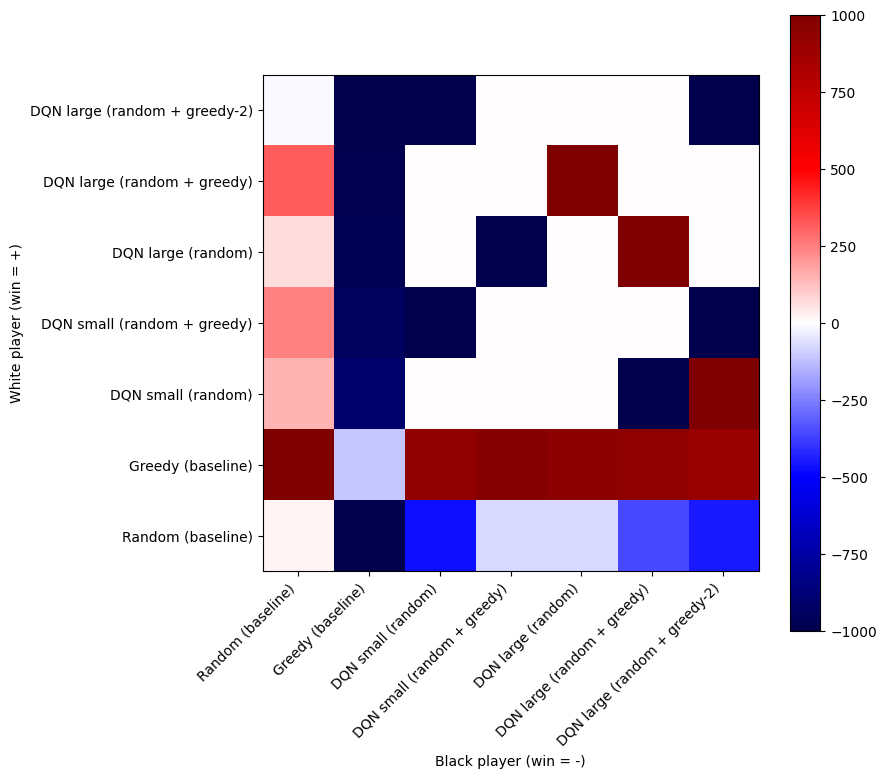

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(net_wins, cmap="seismic", interpolation="none", origin="lower", vmin=-1000, vmax=1000)
fig.colorbar(img, ax=ax)
ax.set_xticks(np.arange(len(white_model_names)))
ax.set_xticklabels(white_model_names, rotation=45, horizontalalignment="right")
ax.set_yticks(np.arange(len(black_model_names)))
ax.set_yticklabels(black_model_names, rotation=0, horizontalalignment="right")
ax.set_ylabel("White player (win = +)")
ax.set_xlabel("Black player (win = -)")
plt.show()

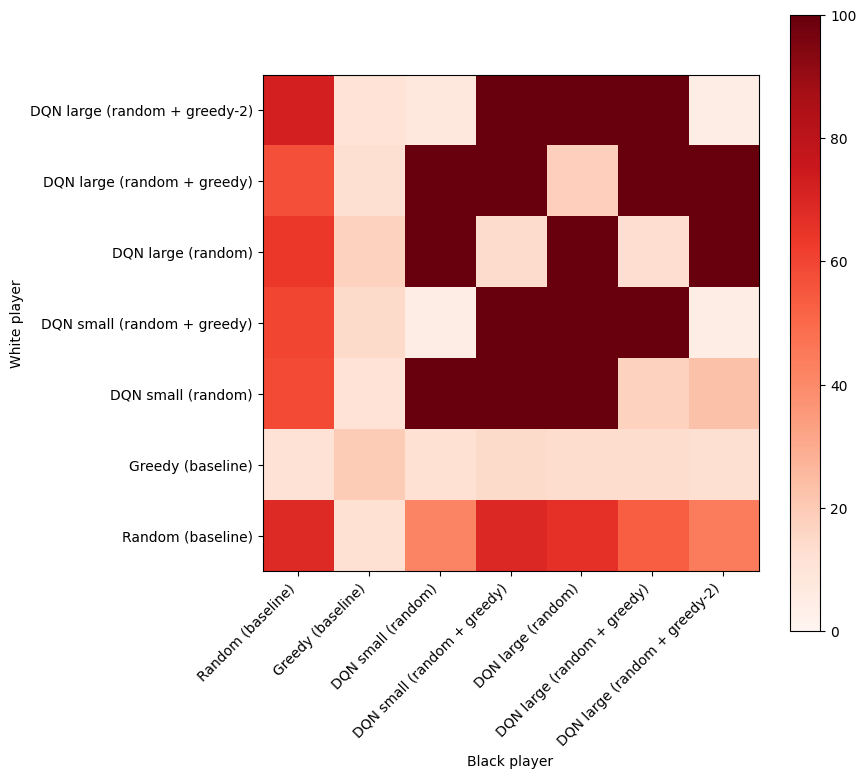

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(games_moves_df.to_numpy(), cmap="Reds", interpolation="none", origin="lower", vmin=0, vmax=100)
fig.colorbar(img, ax=ax)
ax.set_xticks(np.arange(len(white_model_names)))
ax.set_xticklabels(white_model_names, rotation=45, horizontalalignment="right")
ax.set_yticks(np.arange(len(black_model_names)))
ax.set_yticklabels(black_model_names, rotation=0, horizontalalignment="right")
ax.set_ylabel("White player")
ax.set_xlabel("Black player")
plt.show()